# 如果可以簡單，誰想要複雜？


## 組員名單
* 黃靖涵
* 陳恩穎
* 蔡苑萍
* 鍾秉諮
* 黃于軒
* 鐘珮瑄

GitHub: https://github.com/chungFTF/NTU-2022-IM5056-SLDL-Final-Project/

裡面包含所有程式碼以及資料集

## import package

In [3]:
# Data Analysis
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline
sns.set_theme()

# Dimension reduction
from sklearn.decomposition import TruncatedSVD

# Model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder


# Text Processing 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Other
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# NLTK resource
import nltk
# nltk.download('punkt')  # for word_tokenize
# nltk.download('wordnet')  # for WordNetLemmatizer
# nltk.download('omw-1.4')
# nltk.download('stopwords')

import emoji

# keras package
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping


## Preprocessing

To maintain program readability, please refer to this link in our GitHub: https://github.com/chungFTF/NTU-2022-IM5056-SLDL-Final-Project/tree/main/code

## Read data

In [5]:
data = pd.read_csv('../data/kaggle+twitter.csv')
data

,type,flat
0,INFJ,deal dr doorslam overreact one someon life dep...
1,ENTP,sound like typic trait role se h fe lack ethic...
2,INFP,coach biggest person nfl rex ryan think evil o...
3,INFP,haha wow interest sure yeah guess ok pixi time...
4,ENTP,know hate anyway rack disprin gon na play vide...
...,...,...
8767,INFJ,correct went troubl becom dish end irrespect d...
8768,ENFP,trick know valu know passion find group peopl ...
8769,INFP,ok talk friend age lot late go pose question f...
8770,INFP,even loner get lone feel like hard hard relati...


## EDA

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8772 entries, 0 to 8771
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8772 non-null   object
 1   flat    8772 non-null   object
dtypes: object(2)
memory usage: 137.2+ KB


In [18]:
# Data distribution of 16 types
n_colors=16
color = px.colors.sample_colorscale('Purpor_r', [n/(n_colors -1) for n in range(n_colors)])
df_count = data['type'].value_counts()
df_count = df_count.rename_axis('type').reset_index(name='counts')
fig = px.bar(df_count, x='type', y='counts',
            color='type', color_discrete_sequence=color,
            # opacity=0.7,
            title='Type count (Kaggle+Twitter)',
            width=1000,
            height=600)
fig.show()

In [21]:
def WordCount(sentence: str):
    stripped = sentence.strip()  # str
    # print(type(stripped))
    splitted = stripped.split(' ')  # list
    # print(type(splitted))
    return len(splitted)
# Distribution of Lengths of all Posts
data_wordcount = data['flat'].apply(WordCount)
fig = px.histogram(data_wordcount, x='flat',
                title='Distribution of Lengths of all Posts',
                color_discrete_sequence=["lightsteelblue"],
                labels={"flat": "words"},
                width=1000, height=600)
fig.update_traces(marker_line_width=1, marker_line_color="white")
fig.show()

### Word Cloud
Create Word Cloud of 16 types based on preprocessed tokens

In [23]:
# Tokens group by type
df_multi_word = data.groupby(['type'])['flat'].apply(lambda x: ' '.join(x)).reset_index()
df_multi_word

,type,flat
0,ENFJ,absolut care wrong firstx import find right ra...
1,ENFP,smoke year long enough know need quit lung eve...
2,ENTJ,woman lie note make feel anymor stand back bac...
3,ENTP,sound like typic trait role se h fe lack ethic...
4,ESFJ,pothead tri cocain coupl time mdma ecstasi spe...
5,ESFP,social descript fit better probabl descript ev...
6,ESTJ,stereotyp help sorri help realli well said rig...
7,ESTP,know cooler side pillow haha actual said exact...
8,INFJ,deal dr doorslam overreact one someon life dep...
9,INFP,coach biggest person nfl rex ryan think evil o...


In [24]:
def getSortFreqDictForText(sentence)->dict:
    # making dict for counting frequencies
    dict_freq = {}
    for word in sentence.split(" "):
        freq = dict_freq.get(word, 0)  # specify the default value
        dict_freq[word] = freq + 1
    # sort by frequency
    result = dict(sorted(dict_freq.items(), key=lambda item: item[1], reverse=True))
    return result
def createWordCloud(freq_dict: dict):
    '''
    Input: Frequency dictionary
    Outpue: Word cloud object
    Default max_words is 500.
    '''
    wc = WordCloud(background_color="white", colormap='tab20c',
                   max_words=500, width=600, height=400,
                   stopwords=None,
                   prefer_horizontal=1.0)
    return wc.generate_from_frequencies(freq_dict)
# Create dictionary with frequency
df_multi_word['freq_dict'] = df_multi_word['flat'].apply(getSortFreqDictForText)
df_multi_word

,type,flat,freq_dict
0,ENFJ,absolut care wrong firstx import find right ra...,"{'love': 2014, 'like': 2004, 'think': 1489, 'p..."
1,ENFP,smoke year long enough know need quit lung eve...,"{'like': 6940, 'think': 4838, 'peopl': 3886, '..."
2,ENTJ,woman lie note make feel anymor stand back bac...,"{'like': 2288, 'think': 1744, 'get': 1546, 'on..."
3,ENTP,sound like typic trait role se h fe lack ethic...,"{'like': 6749, 'think': 5031, 'one': 4454, 'ge..."
4,ESFJ,pothead tri cocain coupl time mdma ecstasi spe...,"{'love': 2223, 'amp': 1770, 'thank': 1726, 'ne..."
5,ESFP,social descript fit better probabl descript ev...,"{'amp': 3428, 'love': 2504, 'thank': 2365, 'ge..."
6,ESTJ,stereotyp help sorri help realli well said rig...,"{'new': 1182, 'today': 1081, 'see': 1025, 'get..."
7,ESTP,know cooler side pillow haha actual said exact...,"{'get': 1328, 'like': 1297, 'go': 1052, 'amp':..."
8,INFJ,deal dr doorslam overreact one someon life dep...,"{'like': 13268, 'think': 10409, 'peopl': 8507,..."
9,INFP,coach biggest person nfl rex ryan think evil o...,"{'like': 17518, 'think': 13279, 'feel': 10450,..."


In [25]:
multi_type_list = df_multi_word['type'].unique()

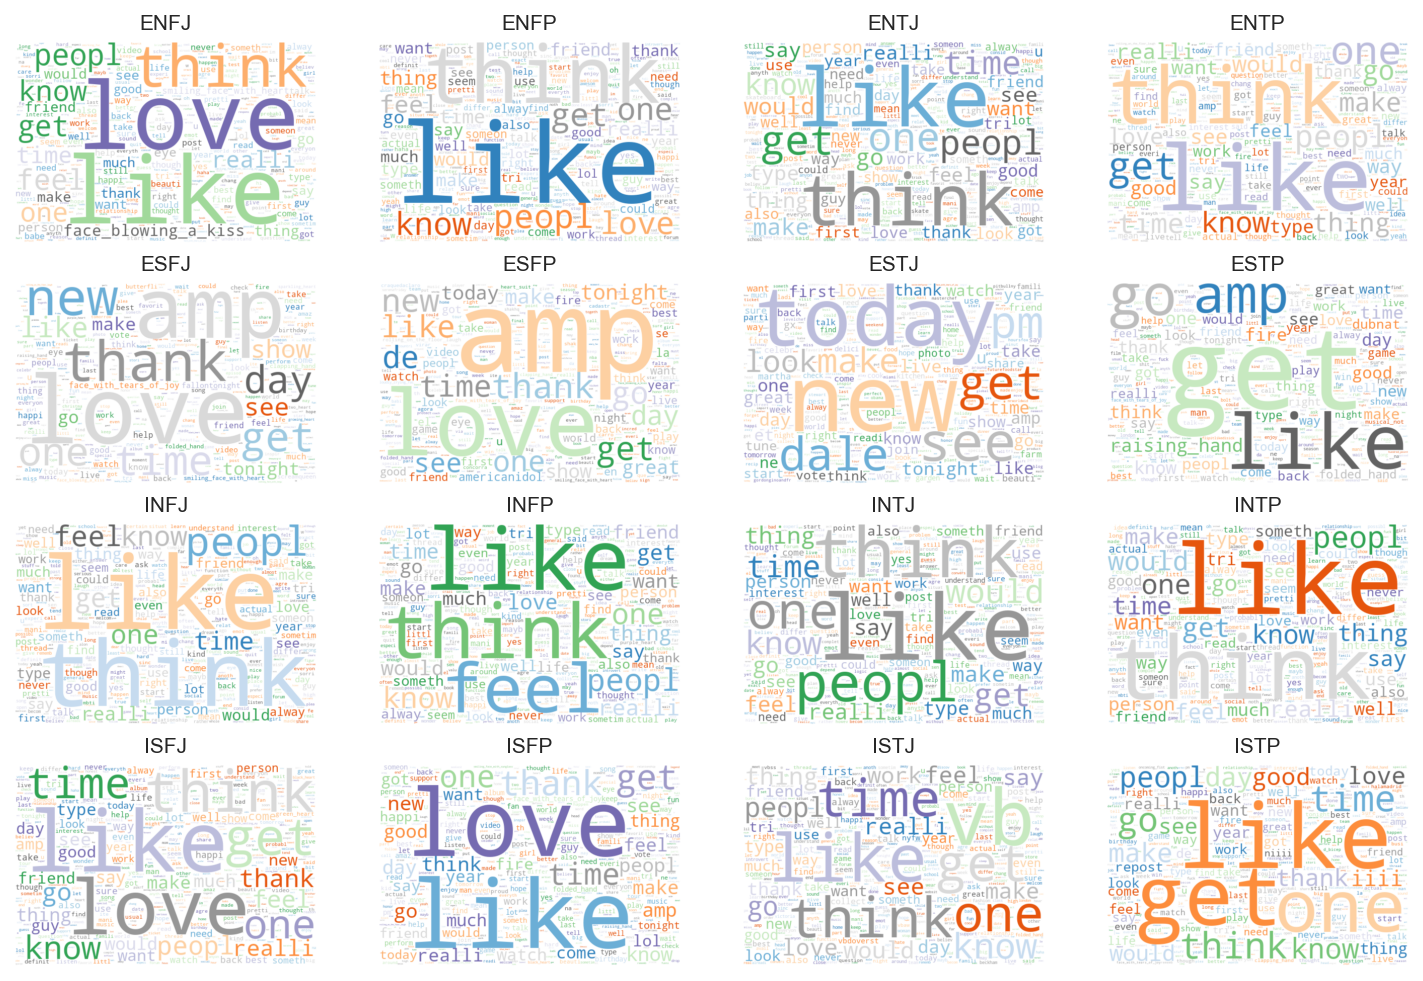

In [27]:
fig = plt.figure(figsize=(12,8), dpi=150)
for idx, mbti in enumerate(multi_type_list):
    ax = fig.add_subplot(4, 4, idx+1)
    freq_dict = getSortFreqDictForText(df_multi_word['flat'][idx])
    wordcloud = createWordCloud(freq_dict)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis('off')
    ax.set_title(mbti, fontsize=10)
fig.show()
# fig.savefig('../img/wordcloud.png')

## Feature engineering
### TF-IDF
不設任何限制的 Tf-IDf 會有 78195 個 features

In [7]:
vectorizer = TfidfVectorizer(analyzer="word",
                          max_df=0.9,
                          max_features=5000,
                          lowercase=None,
                          ngram_range=(1,1)).fit(data['flat'])
X_tfidf = vectorizer.transform(data['flat'])
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names())
df_tfidf

,ab,abandon,abc,aben,abil,abl,abnorm,abort,abroad,absenc,...,yummi,yup,zac,zealand,zen,zero,zodiac,zombi,zone,zoom
0,0.0,0.0,0.0,0.0,0.000000,0.025527,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.024355,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.047265,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.0,0.0,0.0,0.0,0.000000,0.023799,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
8768,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
8769,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
8770,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


In [8]:
# top words in entire corpus
reverse_dic = {}
for key in vectorizer.vocabulary_:
    reverse_dic[vectorizer.vocabulary_[key]] = key
top_tfidf = np.asarray(np.argsort(np.sum(X_tfidf, axis=0))[0,-20:][0, ::-1]).flatten()
[reverse_dic[v] for v in top_tfidf]

['type',
 'love',
 'say',
 'want',
 'person',
 'friend',
 'well',
 'much',
 'see',
 'way',
 'good',
 'tri',
 'someth',
 'lot',
 'also',
 'use',
 'thank',
 'work',
 'alway',
 'even']

### TruncatedSVD
計算出 100 個奇異值最大的值

In [9]:
svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42).fit(X_tfidf)
X_svd = svd.transform(X_tfidf)
X_svd.shape

(8772, 100)

In [10]:
df_svd = pd.DataFrame(X_svd)
df_svd

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.482420,-0.054900,0.165754,0.137907,-0.090523,-0.130968,-0.007263,-0.003160,-0.195502,-0.101533,...,0.008250,-0.015608,-0.028871,-0.049656,0.006999,-0.008920,0.012398,0.026457,-0.047500,0.021724
1,0.300414,0.107970,0.009771,-0.008072,-0.020828,-0.036371,0.065174,0.017251,-0.054143,0.018038,...,0.045447,0.024125,-0.006899,0.023422,-0.014418,-0.040958,-0.004919,0.012816,0.010721,-0.048443
2,0.423000,-0.040137,-0.067090,-0.065724,0.006419,-0.048867,-0.020411,-0.006805,0.048603,0.086573,...,-0.049533,-0.012126,-0.011647,-0.006056,-0.047217,0.004936,0.023262,-0.005892,-0.038987,-0.012414
3,0.335294,-0.029737,0.097189,0.152882,-0.063363,0.012704,-0.023987,0.054896,-0.141937,-0.048115,...,0.006612,0.031246,-0.003751,-0.018490,0.007368,0.063386,0.038406,-0.018261,0.003710,-0.007818
4,0.314965,-0.058591,0.025039,-0.019694,0.019484,0.097103,0.008525,-0.002613,0.004447,0.003528,...,0.011348,-0.021610,0.021697,0.006065,-0.012019,0.010944,-0.010526,-0.045269,-0.015071,-0.020520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.368251,-0.021854,0.055602,-0.082237,0.002836,-0.032525,0.012731,0.015290,-0.035442,-0.015772,...,-0.041194,-0.000948,0.010715,0.011638,0.012519,0.003274,-0.028633,-0.013365,-0.038673,0.042123
8768,0.436874,-0.023953,-0.022742,-0.041345,-0.013621,-0.063066,0.084853,-0.014968,-0.070830,-0.055997,...,-0.012015,-0.049092,0.005821,0.017893,0.008635,-0.034856,0.006131,0.009405,0.010203,-0.010684
8769,0.427306,-0.098727,-0.032815,-0.020958,-0.001580,-0.075581,-0.042862,-0.040223,0.027843,0.048127,...,0.022234,-0.047725,-0.027319,-0.008467,0.005122,0.033390,0.018604,-0.010541,-0.031414,0.024855
8770,0.453849,-0.088360,0.011409,-0.062319,0.022284,-0.007055,-0.042342,-0.030683,-0.061540,0.001607,...,0.035682,0.064092,0.024641,0.022537,0.024230,0.002716,-0.048397,-0.001318,0.017426,-0.000616


## Binary Classification

In [32]:
# get binary labeled data
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0

    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data_labeled = data.join(data.apply (lambda row: get_types (row),axis=1))
data_labeled

,type,flat,IE,NS,TF,JP
0,INFJ,deal dr doorslam overreact one someon life dep...,1,1,0,1
1,ENTP,sound like typic trait role se h fe lack ethic...,0,1,1,0
2,INFP,coach biggest person nfl rex ryan think evil o...,1,1,0,0
3,INFP,haha wow interest sure yeah guess ok pixi time...,1,1,0,0
4,ENTP,know hate anyway rack disprin gon na play vide...,0,1,1,0
...,...,...,...,...,...,...
8767,INFJ,correct went troubl becom dish end irrespect d...,1,1,0,1
8768,ENFP,trick know valu know passion find group peopl ...,0,1,0,0
8769,INFP,ok talk friend age lot late go pose question f...,1,1,0,0
8770,INFP,even loner get lone feel like hard hard relati...,1,1,0,0


In [33]:
# Plotting Classification class vs Frequency plot for IE, NS, TF, JP
I,N,T,J = data_labeled['IE'].value_counts()[0], data_labeled['NS'].value_counts()[0], data_labeled['TF'].value_counts()[0], data_labeled['JP'].value_counts()[0]
E,S,F,P = data_labeled['IE'].value_counts()[1], data_labeled['NS'].value_counts()[1], data_labeled['TF'].value_counts()[1], data_labeled['JP'].value_counts()[1]

dimensions = ['Introversion-Extraversion','Intuition-Sensing','Thinking-Feeling','Judging-Perceiving']
all = len(data_labeled)

fig = go.Figure()
fig.add_trace(go.Bar(name='I,N,T,J', x=dimensions, y=(I,N,T,J), customdata=[I/all,N/all,T/all,J/all], marker=dict(color=px.colors.qualitative.Pastel1[1])))
fig.add_trace(go.Bar(name='E,S,F,P', x=dimensions, y=(E,S,F,P), customdata=[E/all,S/all,F/all,P/all], marker=dict(color=px.colors.qualitative.Pastel1[3])))
fig.update_layout(barmode='group',title_text="Classification class vs Frequency plot", width=800)
fig.update_traces(hovertemplate='Actual: %{value}<br>Percent: %{customdata:,.2f}')
fig.show()

#### 相關係數
An assumption made in our model is that each letter type is independent of other types i.e. A person’s introversion/extroversion is not related to their judgement/perception. Nevertheless, we want to still test them below using a heat map

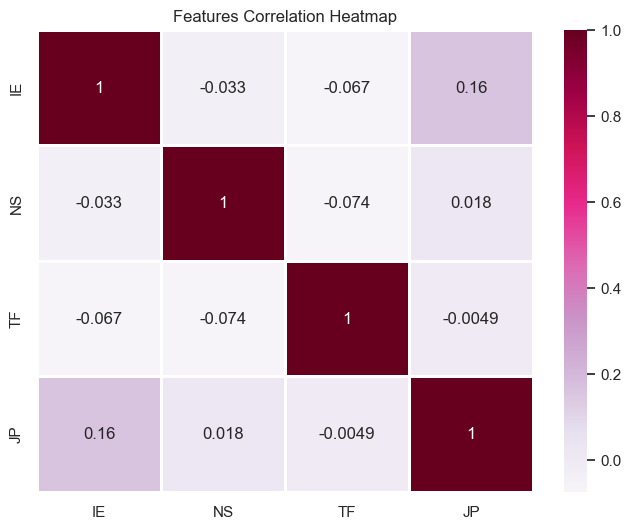

In [35]:
corr = data_labeled[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(8,6))
plt.title('Features Correlation Heatmap', size=12)
sns.heatmap(corr,cmap=plt.cm.PuRd,annot=True,linewidths=1)
plt.show()

#### Training and Testing Split
Only executive one time.

In [36]:
# Train test split
X_train_IE, X_test_IE, Y_train_IE, Y_test_IE = train_test_split(X_svd, data_labeled['IE'], test_size=0.2, random_state=42, stratify=data_labeled['IE'])
X_train_NS, X_test_NS, Y_train_NS, Y_test_NS = train_test_split(X_svd, data_labeled['NS'], test_size=0.2, random_state=42, stratify=data_labeled['NS'])
X_train_TF, X_test_TF, Y_train_TF, Y_test_TF = train_test_split(X_svd, data_labeled['TF'], test_size=0.2, random_state=42, stratify=data_labeled['TF'])
X_train_JP, X_test_JP, Y_train_JP, Y_test_JP = train_test_split(X_svd, data_labeled['JP'], test_size=0.2, random_state=42, stratify=data_labeled['JP'])

In [37]:
IE_dataset = {"X_train": X_train_IE, "X_test": X_test_IE, "Y_train": Y_train_IE, "Y_test": Y_test_IE}
NS_dataset = {"X_train": X_train_NS, "X_test": X_test_NS, "Y_train": Y_train_NS, "Y_test": Y_test_NS}
TF_dataset = {"X_train": X_train_TF, "X_test": X_test_TF, "Y_train": Y_train_TF, "Y_test": Y_test_TF}
JP_dataset = {"X_train": X_train_JP, "X_test": X_test_JP, "Y_train": Y_train_JP, "Y_test": Y_test_JP}

In [38]:
print(f'Each dataset:\nTrain|| X:{X_train_IE.shape}\tY:{Y_train_IE.shape} \nTest || X:{X_test_IE.shape}\tY:{Y_test_IE.shape}\n')

Each dataset:
Train|| X:(7017, 100)	Y:(7017,) 
Test || X:(1755, 100)	Y:(1755,)



#### Model method

In [40]:
def fitCV(model):
    '''
    Input: Base model
    Output: Models for each dimension
    '''
    # Cross validation
    grid1 = GridSearchCV(model,{},cv=10)
    grid2 = GridSearchCV(model,{},cv=10)
    grid3 = GridSearchCV(model,{},cv=10)
    grid4 = GridSearchCV(model,{},cv=10)
    # Fit
    model_IE = grid1.fit(X_train_IE,Y_train_IE)
    model_NS = grid2.fit(X_train_NS,Y_train_NS)
    model_TF = grid3.fit(X_train_TF,Y_train_TF)
    model_JP = grid4.fit(X_train_JP,Y_train_JP)

    return model_IE,model_NS,model_TF,model_JP

def predictCV(model_IE,model_NS,model_TF,model_JP):
    '''
    Input: 4 models
    Output: Predict on test data for each dimension
    '''
    ypredIE = model_IE.best_estimator_.predict(X_test_IE)
    ypredNS = model_NS.best_estimator_.predict(X_test_NS)
    ypredTF = model_TF.best_estimator_.predict(X_test_TF)
    ypredJP = model_JP.best_estimator_.predict(X_test_JP)
    return ypredIE, ypredNS, ypredTF, ypredJP
    
def print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP):
   '''
   Function to print Classification Report of the given model
   This function takes 4 predicted output datasets as input.
   It computes classfication report: accuracy, recall, f1-score.
   It prints classification reports for all 4 predictions (models).
   '''
   print(f'Classification Report for Introversion(I) / Extroversion(E):\n {classification_report(Y_test_IE, ypredIE)}\n')
   print(f'Classification Report for Intuition(N) / Sensing(S):\n {classification_report(Y_test_NS, ypredNS)}\n')
   print(f'Classification Report for Thinking(T) / Feeling(F):\n{classification_report(Y_test_TF, ypredTF)}\n')
   print(f'Classification Report for Judging(J) / Perceiving(P):\n {classification_report(Y_test_JP, ypredJP)}\n')


def print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP):
   cm = confusion_matrix(Y_test_IE, ypredIE)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Reds_r',fmt='g')
   plt.ylabel('Y_test_IE')
   plt.xlabel('ypredIE')
   plt.title('Confusion matrix for Introversion(I) / Extroversion(E): ', size=12)

   cm = confusion_matrix(Y_test_NS, ypredNS)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Greens_r',fmt='g')
   plt.ylabel('Y_test_NS')
   plt.xlabel('ypredNS')
   plt.title('Confusion matrix for Intuition(N) / Sensing(S): ', size=12)

   cm = confusion_matrix(Y_test_TF, ypredTF)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Blues_r',fmt='g')
   plt.ylabel('Y_test_TF')
   plt.xlabel('ypredTF')
   plt.title('Confusion matrix for Thinking(T) / Feeling(F): ', size=12)

   cm = confusion_matrix(Y_test_JP, ypredJP)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Purples_r',fmt='g')
   plt.ylabel('Y_test_JP')
   plt.xlabel('ypredJP')
   plt.title('Confusion matrix for Judging(J) / Perceiving(P): ', size=12)


def print_roc_auc_curve(probIE, probNS, probTF, probJP, title:str):
   fp_IE, tp_IE, _ = roc_curve(Y_test_IE, probIE[:,1])
   fp_NS, tp_NS, _ = roc_curve(Y_test_NS, probNS[:,1])
   fp_TF, tp_TF, _ = roc_curve(Y_test_TF, probTF[:,1])
   fp_JP, tp_JP, _ = roc_curve(Y_test_JP, probJP[:,1])
   plt.figure(figsize=(8,5))
   plt.plot(fp_IE, tp_IE, linestyle=':', color='indianred', label=f'Introversion(I) / Extroversion(E) (area={auc(fp_IE, tp_IE):.2f})',linewidth=1.8)
   plt.plot(fp_NS, tp_NS, linestyle='--', color='darkseagreen', label=f'Intuition(N) / Sensing(S) (area={auc(fp_NS, tp_NS):.2f})',linewidth=1.8)
   plt.plot(fp_TF, tp_TF, linestyle='-.', color='dodgerblue', label=f'Thinking(T) / Feeling(F) (area={auc(fp_TF, tp_TF):.2f})',linewidth=1.8)
   plt.plot(fp_JP, tp_JP, linestyle='--', color='orchid', label=f'Judging(J) / Perceiving(P) (area={auc(fp_TF, tp_TF):.2f})',linewidth=1.8)
   plt.xlabel('False Positive Rate')
   plt.ylabel('True Positive Rate')
   plt.title(title+' ROC Curve')
   plt.legend(loc='best')
   # plt.savefig('../img/ROC_tw_'+title+'.png')

### Training
#### Naive Bayes Model

In [41]:
gNB = GaussianNB()
# Fit
gNB_IE, gNB_NS, gNB_TF, gNB_JP = fitCV(gNB)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(gNB_IE,gNB_NS,gNB_TF,gNB_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.40      0.22      0.29       411
           1       0.79      0.90      0.84      1344

    accuracy                           0.74      1755
   macro avg       0.59      0.56      0.56      1755
weighted avg       0.70      0.74      0.71      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.39      0.25      0.30       253
           1       0.88      0.94      0.91      1502

    accuracy                           0.84      1755
   macro avg       0.64      0.59      0.60      1755
weighted avg       0.81      0.84      0.82      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.76      0.69      0.73       951
           1       0.67      0.74      0.70       804

    accuracy

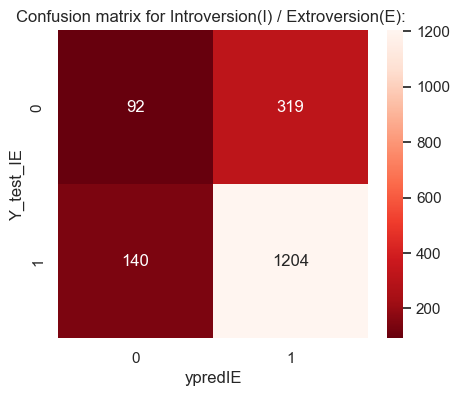

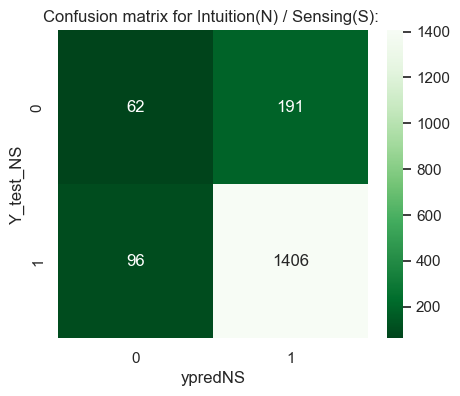

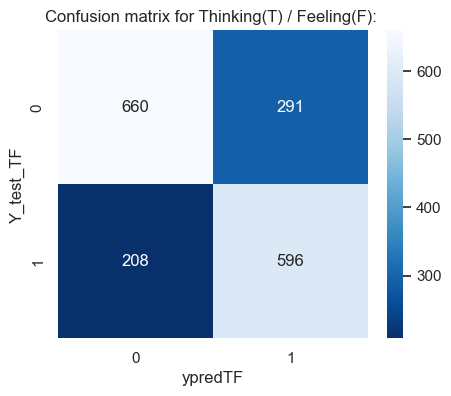

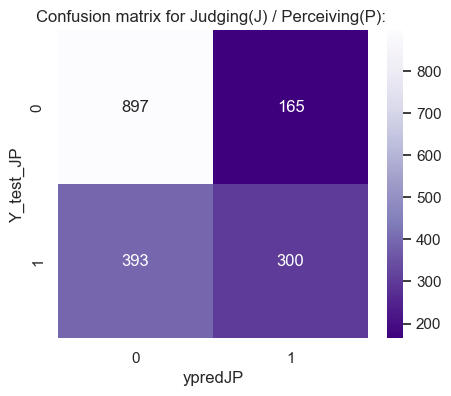

In [42]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

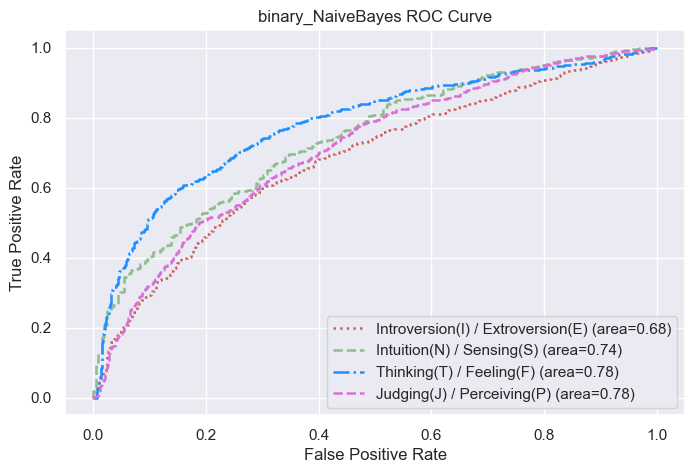

In [43]:
# ROC curve
print_roc_auc_curve(gNB_IE.best_estimator_.predict_proba(X_test_IE),
                    gNB_NS.best_estimator_.predict_proba(X_test_NS),
                    gNB_TF.best_estimator_.predict_proba(X_test_TF),
                    gNB_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_NaiveBayes')

#### Logistic Regression

In [44]:
log = LogisticRegression(random_state=42,max_iter=500)
# Fit
log_IE, log_NS, log_TF, log_JP = fitCV(log)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(log_IE,log_NS,log_TF,log_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.65      0.11      0.18       411
           1       0.78      0.98      0.87      1344

    accuracy                           0.78      1755
   macro avg       0.71      0.54      0.53      1755
weighted avg       0.75      0.78      0.71      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.69      0.04      0.07       253
           1       0.86      1.00      0.92      1502

    accuracy                           0.86      1755
   macro avg       0.78      0.52      0.50      1755
weighted avg       0.84      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       951
           1       0.78      0.76      0.77       804

    accuracy

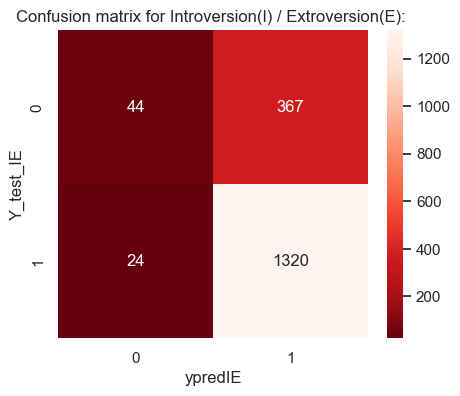

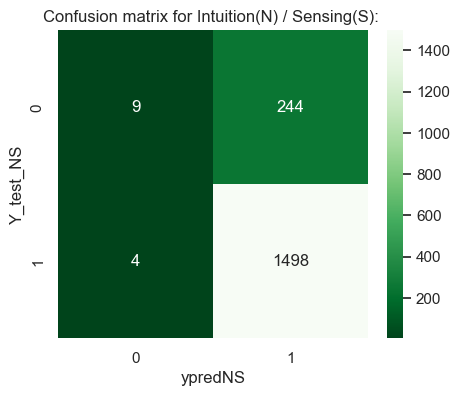

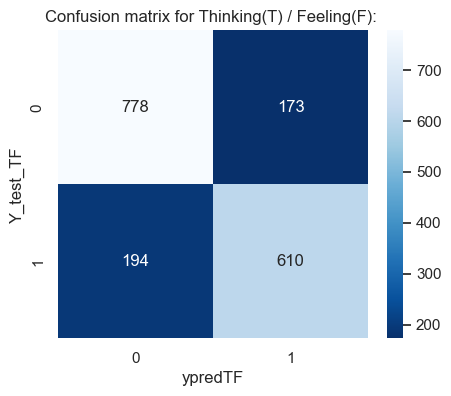

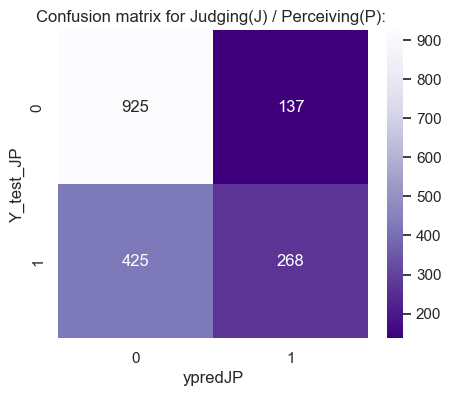

In [45]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

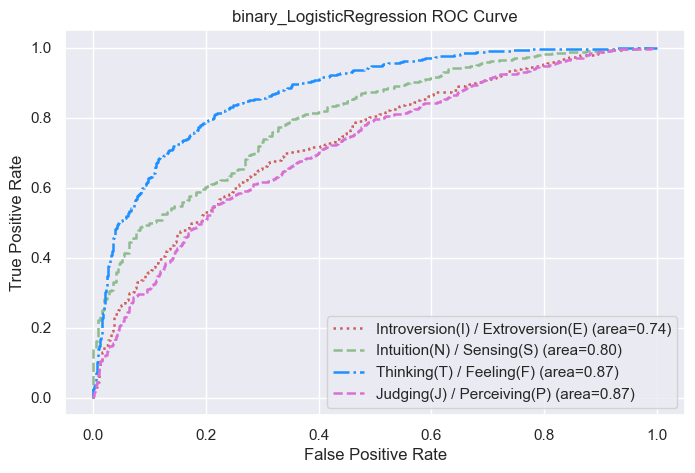

In [46]:
# ROC curve
print_roc_auc_curve(log_IE.best_estimator_.predict_proba(X_test_IE),
                    log_NS.best_estimator_.predict_proba(X_test_NS),
                    log_TF.best_estimator_.predict_proba(X_test_TF),
                    log_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_LogisticRegression')

#### SVM

In [47]:
svm = SVC(random_state=42, probability=True)
# Fit
svm_IE, svm_NS, svm_TF, svm_JP = fitCV(svm)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(svm_IE,svm_NS,svm_TF,svm_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.52      0.03      0.05       411
           1       0.77      0.99      0.87      1344

    accuracy                           0.77      1755
   macro avg       0.65      0.51      0.46      1755
weighted avg       0.71      0.77      0.68      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.71      0.04      0.07       253
           1       0.86      1.00      0.92      1502

    accuracy                           0.86      1755
   macro avg       0.79      0.52      0.50      1755
weighted avg       0.84      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       951
           1       0.78      0.75      0.77       804

    accuracy

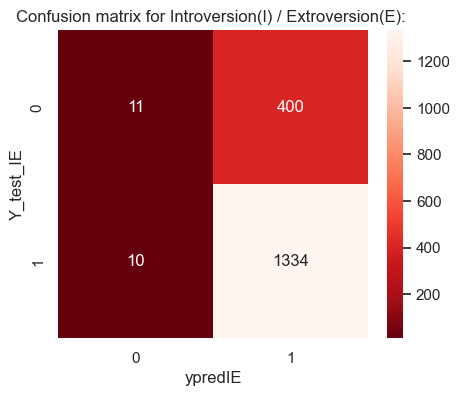

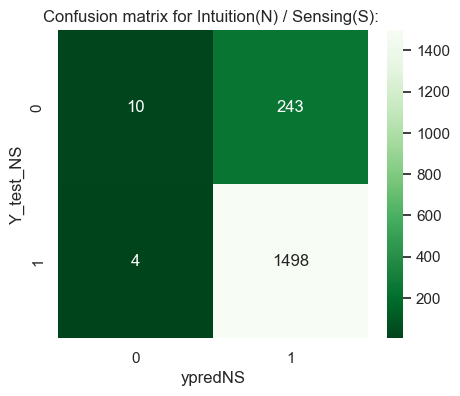

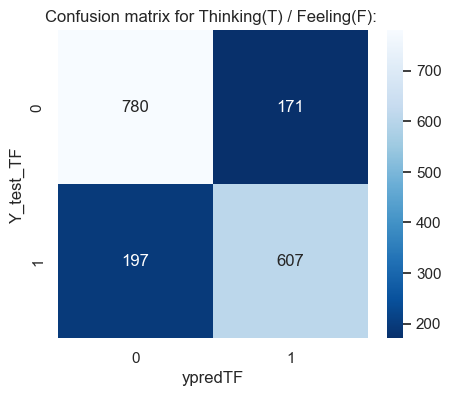

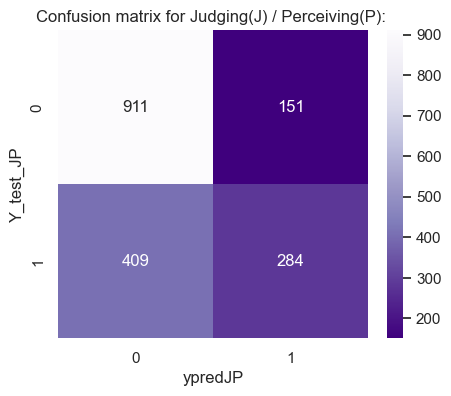

In [48]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

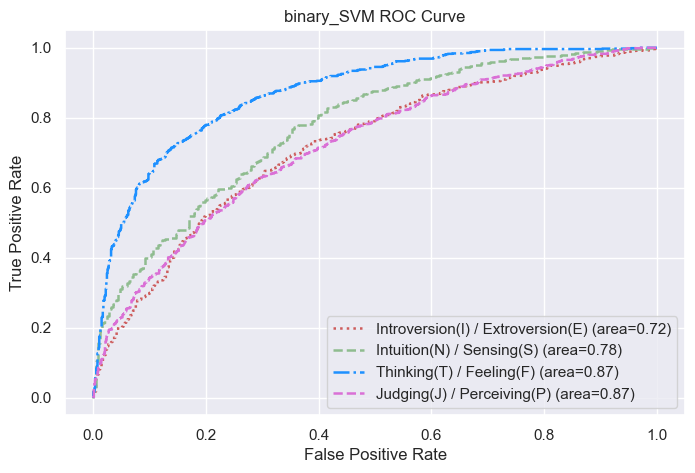

In [49]:
# ROC curve
print_roc_auc_curve(svm_IE.best_estimator_.predict_proba(X_test_IE),
                    svm_NS.best_estimator_.predict_proba(X_test_NS),
                    svm_TF.best_estimator_.predict_proba(X_test_TF),
                    svm_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_SVM')

#### K-Nearest Neighbor (KNN)

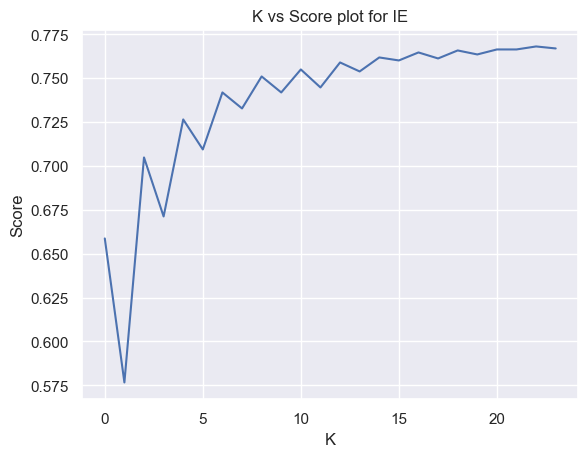

Maximum Accuracy of 0.7680911680911681 at k=23


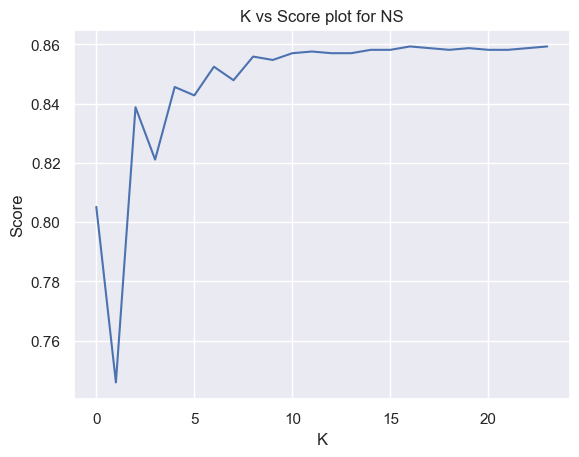

Maximum Accuracy of 0.8592592592592593 at k=17


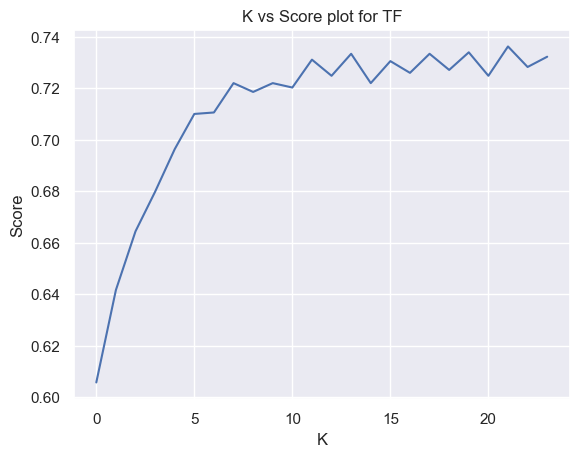

Maximum Accuracy of 0.7361823361823362 at k=22


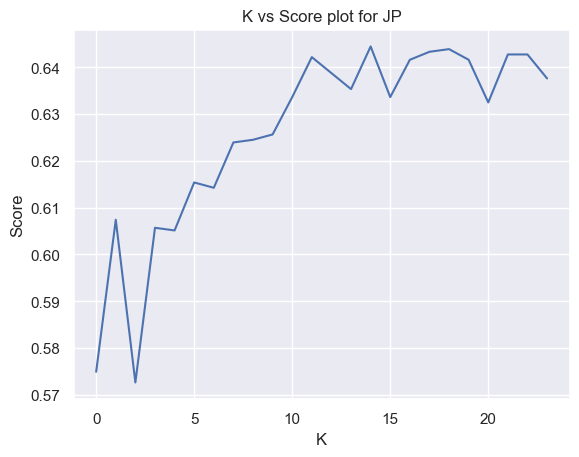

Maximum Accuracy of 0.7361823361823362 at k=22


In [50]:
def plot_graph(val,xlab,ylab,title):
    plt.figure()
    plt.plot(val)
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title)
    plt.show()

# IE prediction
k1_score = []
for i in range(1,25):
    k1 = KNeighborsClassifier(n_neighbors=i)
    k1.fit(X_train_IE, Y_train_IE)
    k1_score.append(k1.score(X_test_IE, Y_test_IE))

df1 = pd.DataFrame(k1_score,columns=['IE'])
plot_graph(k1_score,'K','Score','K vs Score plot for IE')
print(f'Maximum Accuracy of {df1.max()[0]} at k={df1.idxmax()[0]+1}')

# NS prediction
k2_score = []
for i in range(1,25):
	k2 = KNeighborsClassifier(n_neighbors=i)
	k2.fit(X_train_NS, Y_train_NS)
	k2_score.append(k2.score(X_test_NS, Y_test_NS))

df2 = pd.DataFrame(k2_score,columns=['NS'])
plot_graph(k2_score,'K','Score','K vs Score plot for NS')
print(f'Maximum Accuracy of {df2.max()[0]} at k={df2.idxmax()[0]+1}')

# TF prediction
k3_score = []
for i in range(1,25):
  k3 = KNeighborsClassifier(n_neighbors=i)
  k3.fit(X_train_TF, Y_train_TF)
  k3_score.append(k3.score(X_test_TF, Y_test_TF))

df3 = pd.DataFrame(k3_score,columns=['TF'])
plot_graph(k3_score,'K','Score','K vs Score plot for TF')
print(f'Maximum Accuracy of {df3.max()[0]} at k={df3.idxmax()[0]+1}')

# JP prediction
k4_score=[]
for i in range(1,25):
  k4 = KNeighborsClassifier(n_neighbors=i)
  k4.fit(X_train_JP, Y_train_JP)
  k4_score.append(k4.score(X_test_JP, Y_test_JP))

df4 = pd.DataFrame(k3_score,columns=['JP'])
plot_graph(k4_score,'K','Score','K vs Score plot for JP')
print(f'Maximum Accuracy of {df4.max()[0]} at k={df4.idxmax()[0]+1}')

In [51]:
kbestIE = KNeighborsClassifier(n_neighbors=df1.idxmax()[0]+1)
knn_IE = kbestIE.fit(X_train_IE,Y_train_IE)
ypredIE = knn_IE.predict(X_test_IE)

kbestNS = KNeighborsClassifier(n_neighbors=df2.idxmax()[0]+1)
knn_NS = kbestNS.fit(X_train_NS,Y_train_NS)
ypredNS = knn_NS.predict(X_test_NS)

kbestTF = KNeighborsClassifier(n_neighbors=df3.idxmax()[0]+1)
knn_TF = kbestTF.fit(X_train_TF,Y_train_TF)
ypredTF = knn_TF.predict(X_test_TF)

kbestJP = KNeighborsClassifier(n_neighbors=df4.idxmax()[0]+1)
knn_JP = kbestJP.fit(X_train_JP,Y_train_JP)
ypredJP = knn_JP.predict(X_test_JP)

# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.57      0.04      0.08       411
           1       0.77      0.99      0.87      1344

    accuracy                           0.77      1755
   macro avg       0.67      0.52      0.47      1755
weighted avg       0.72      0.77      0.68      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.64      0.06      0.10       253
           1       0.86      0.99      0.92      1502

    accuracy                           0.86      1755
   macro avg       0.75      0.53      0.51      1755
weighted avg       0.83      0.86      0.81      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       951
           1       0.70      0.75      0.72       804

    accuracy

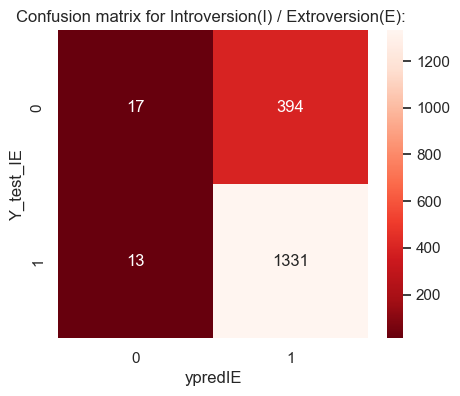

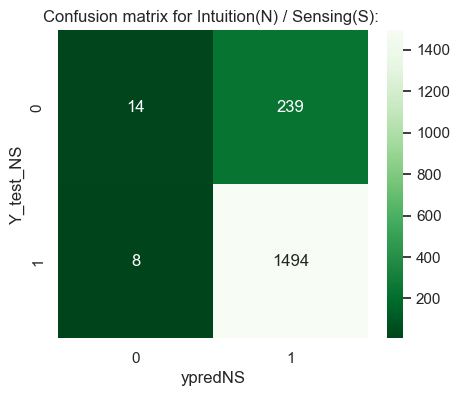

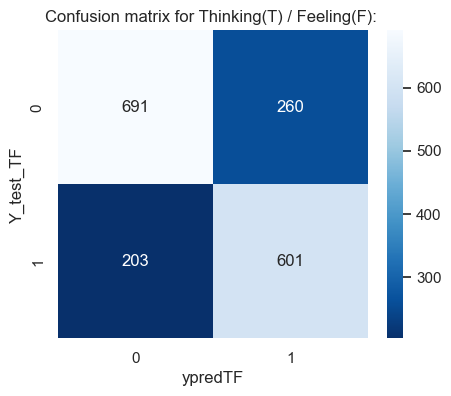

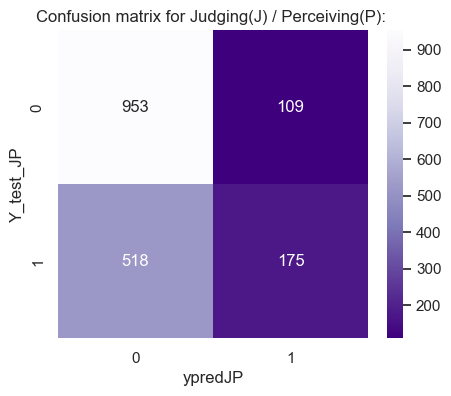

In [52]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

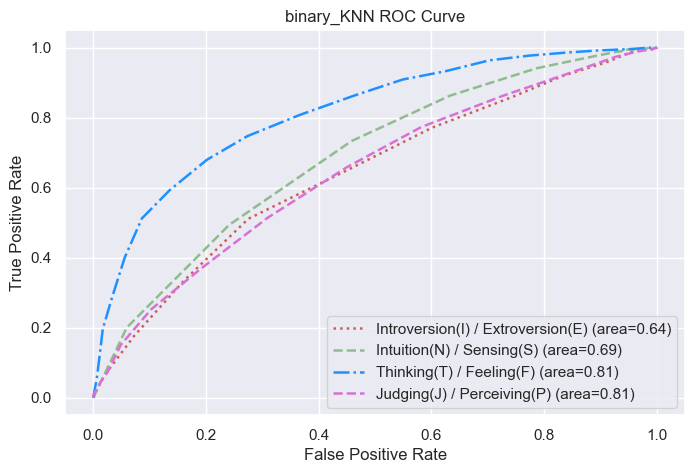

In [53]:
# ROC curve
print_roc_auc_curve(kbestIE.predict_proba(X_test_IE),
                    kbestNS.predict_proba(X_test_NS),
                    kbestTF.predict_proba(X_test_TF),
                    kbestJP.predict_proba(X_test_JP),
                    title='binary_KNN')

#### Decision Tree

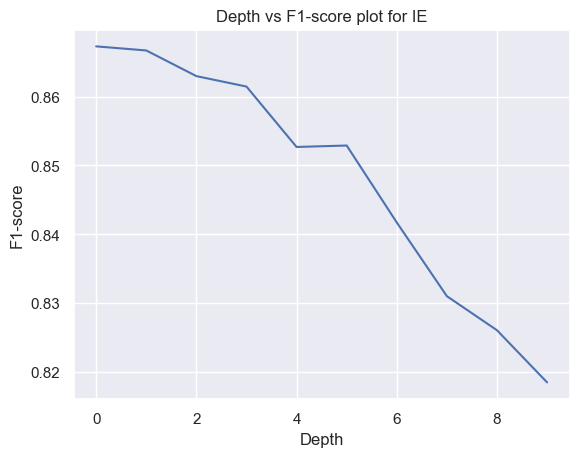

Maximum F1-score of 0.8673122969336372 at depth=1


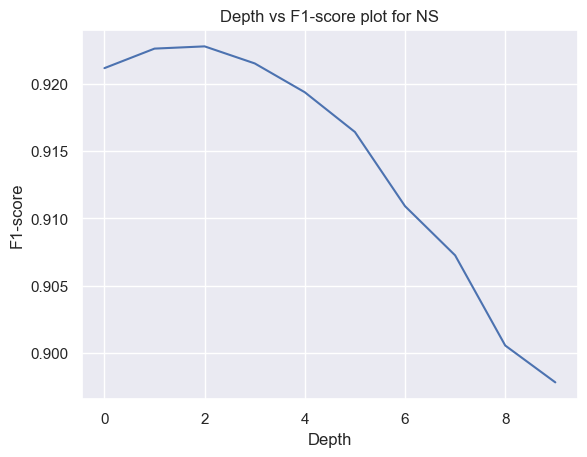

Maximum F1-score of 0.9227571566155002 at depth=3


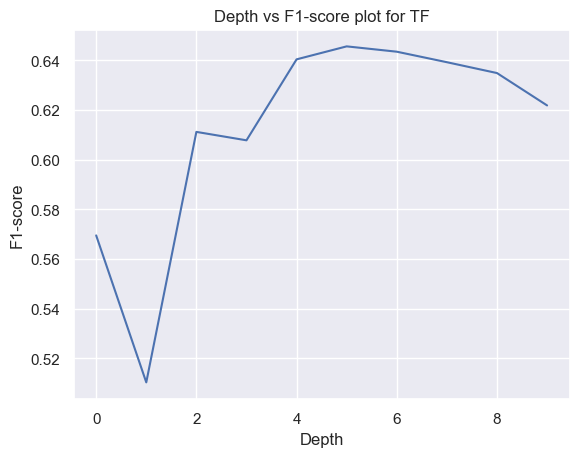

Maximum F1-score of 0.6456490545552466 at depth=6


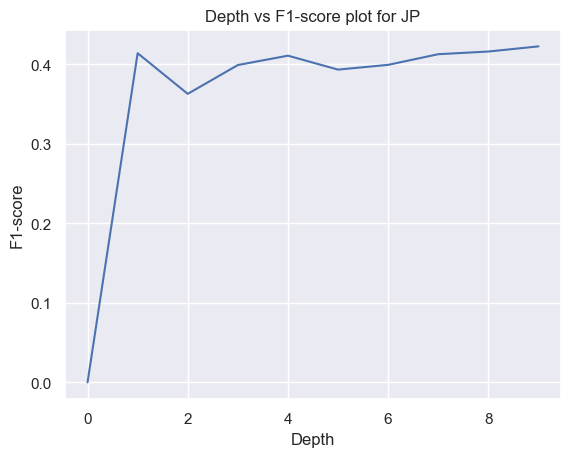

Maximum F1-score of 0.42261435170990236 at depth=10


In [54]:
def plot_graph(val, title):
    plt.plot(val)
    plt.ylabel('F1-score')
    plt.xlabel('Depth')
    plt.title(title)
    plt.show()

# IE prediction
k1_score = []
for i in range(1,11):
    k1_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k1_cart, X_train_IE, Y_train_IE, cv=10, scoring='f1')
    k1_score.append(score.mean())
df1 = pd.DataFrame(k1_score,columns=['IE'])
plot_graph(k1_score,'Depth vs F1-score plot for IE')
print(f'Maximum F1-score of {df1.max()[0]} at depth={df1.idxmax()[0]+1}')

# NS prediction
k2_score = []
for i in range(1,11):
    k2_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k2_cart, X_train_NS, Y_train_NS, cv=10, scoring='f1')
    k2_score.append(score.mean())
df2 = pd.DataFrame(k2_score,columns=['NS'])
plot_graph(k2_score,'Depth vs F1-score plot for NS')
print(f'Maximum F1-score of {df2.max()[0]} at depth={df2.idxmax()[0]+1}')

# TF prediction
k3_score = []
for i in range(1,11):
    k3_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k3_cart, X_train_TF, Y_train_TF, cv=10, scoring='f1')
    k3_score.append(score.mean())
df3 = pd.DataFrame(k3_score,columns=['TF'])
plot_graph(k3_score,'Depth vs F1-score plot for TF')
print(f'Maximum F1-score of {df3.max()[0]} at depth={df3.idxmax()[0]+1}')

# JP prediction
k4_score=[]
for i in range(1,11):
    k4_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k4_cart, X_train_JP, Y_train_JP, cv=10, scoring='f1')
    k4_score.append(score.mean())
df4 = pd.DataFrame(k4_score,columns=['JP'])
plot_graph(k4_score,'Depth vs F1-score plot for JP')
print(f'Maximum F1-score of {df4.max()[0]} at depth={df4.idxmax()[0]+1}')

In [55]:
dtbestIE = DecisionTreeClassifier(criterion="gini", max_depth=df1.idxmax()[0]+1, random_state=42)
dt_IE = dtbestIE.fit(X_train_IE,Y_train_IE)
ypredIE = dt_IE.predict(X_test_IE)

dtbestNS = DecisionTreeClassifier(criterion="gini", max_depth=df2.idxmax()[0]+1, random_state=42)
dt_NS = dtbestNS.fit(X_train_NS,Y_train_NS)
ypredNS = dt_NS.predict(X_test_NS)

dtbestTF = DecisionTreeClassifier(criterion="gini", max_depth=df3.idxmax()[0]+1, random_state=42)
dt_TF = dtbestTF.fit(X_train_TF,Y_train_TF)
ypredTF = dt_TF.predict(X_test_TF)

dtbestJP = DecisionTreeClassifier(criterion="gini", max_depth=df4.idxmax()[0]+1, random_state=42)
dt_JP = dtbestJP.fit(X_train_JP,Y_train_JP)
ypredJP = dt_JP.predict(X_test_JP)

# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       411
           1       0.77      1.00      0.87      1344

    accuracy                           0.77      1755
   macro avg       0.38      0.50      0.43      1755
weighted avg       0.59      0.77      0.66      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.77      0.04      0.08       253
           1       0.86      1.00      0.92      1502

    accuracy                           0.86      1755
   macro avg       0.81      0.52      0.50      1755
weighted avg       0.85      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       951
           1       0.69      0.58      0.63       804

    accuracy

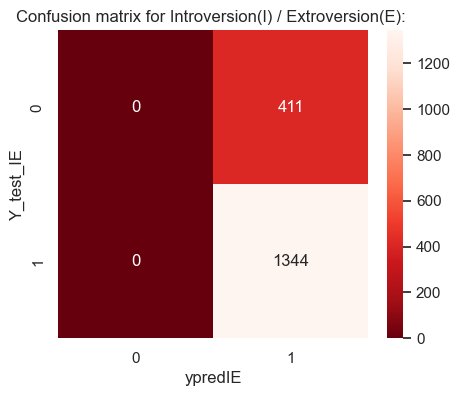

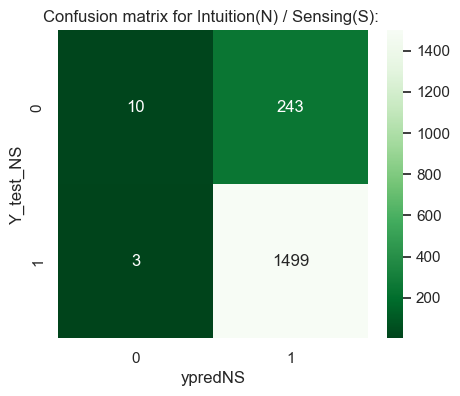

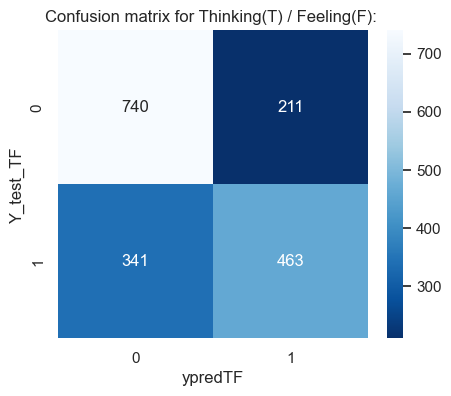

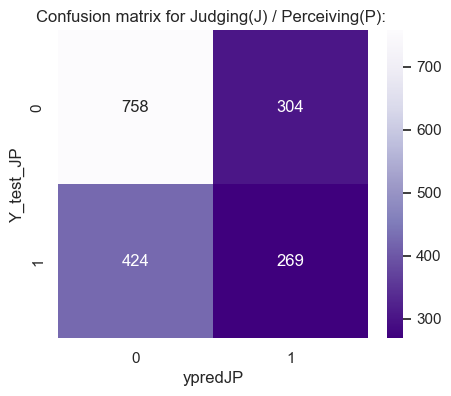

In [56]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

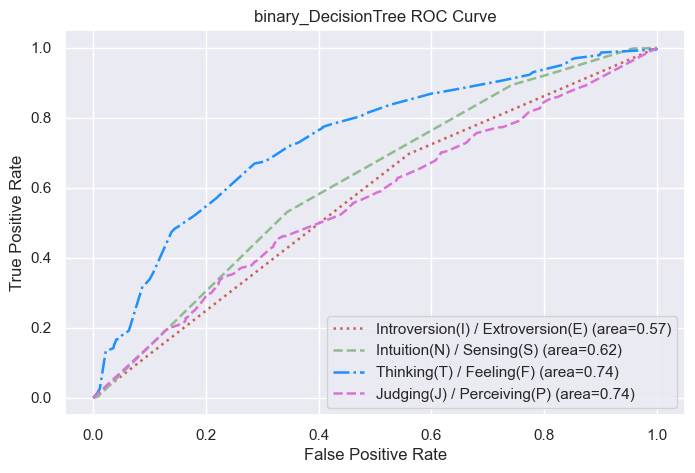

In [57]:
# ROC curve
print_roc_auc_curve(dtbestIE.predict_proba(X_test_IE),
                    dtbestNS.predict_proba(X_test_NS),
                    dtbestTF.predict_proba(X_test_TF),
                    dtbestJP.predict_proba(X_test_JP),
                    title='binary_DecisionTree')

#### Random Forest

In [58]:
rf = RandomForestClassifier(n_estimators=200,  # after tuning
                            random_state=42)
# Fit
rf_IE, rf_NS, rf_TF, rf_JP = fitCV(rf)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(rf_IE,rf_NS,rf_TF,rf_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.44      0.02      0.04       411
           1       0.77      0.99      0.87      1344

    accuracy                           0.76      1755
   macro avg       0.61      0.51      0.45      1755
weighted avg       0.69      0.76      0.67      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.69      0.04      0.07       253
           1       0.86      1.00      0.92      1502

    accuracy                           0.86      1755
   macro avg       0.78      0.52      0.50      1755
weighted avg       0.84      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       951
           1       0.77      0.67      0.72       804

    accuracy

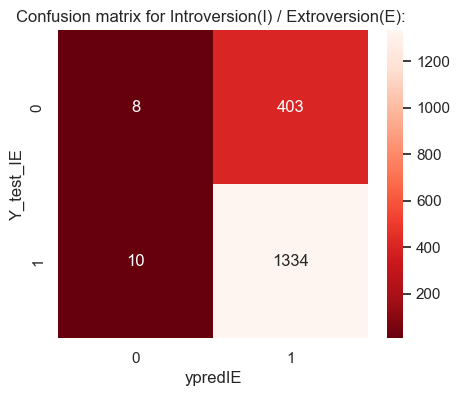

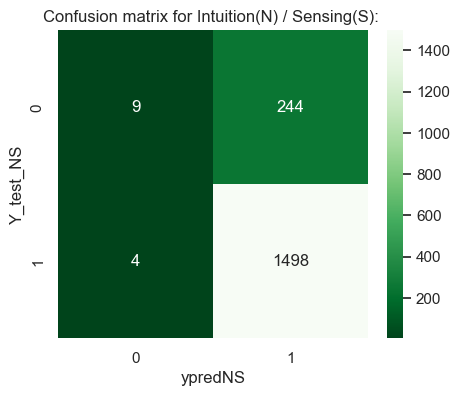

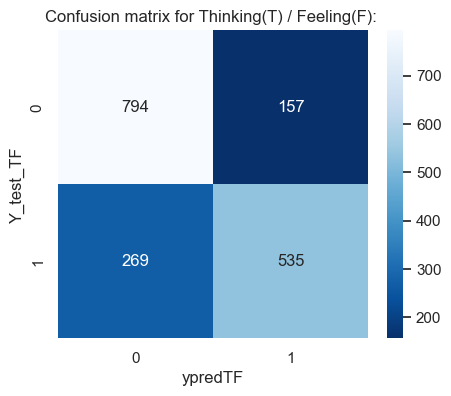

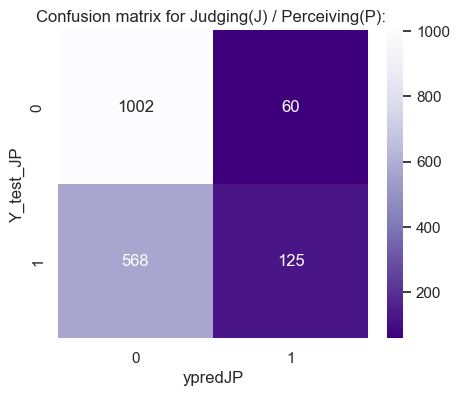

In [59]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

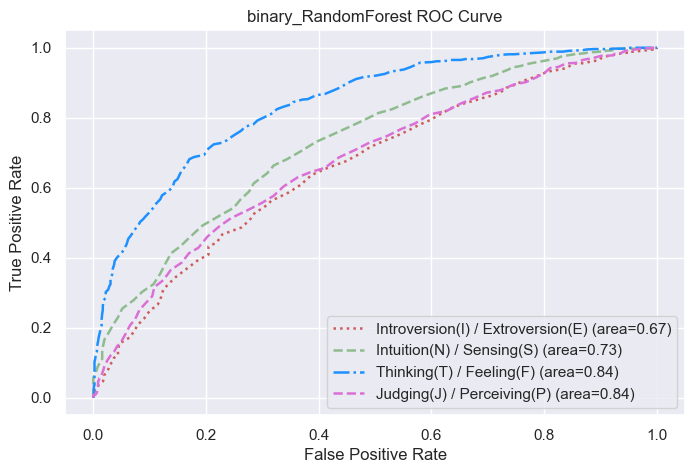

In [60]:
# ROC curve
print_roc_auc_curve(rf_IE.best_estimator_.predict_proba(X_test_IE),
                    rf_NS.best_estimator_.predict_proba(X_test_NS),
                    rf_TF.best_estimator_.predict_proba(X_test_TF),
                    rf_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_RandomForest')

#### Gradient Boost

In [64]:
gb = GradientBoostingClassifier(random_state=42)
# Fit
gb_IE, gb_NS, gb_TF, gb_JP = fitCV(gb)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(gb_IE,gb_NS,gb_TF,gb_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.65      0.11      0.18       411
           1       0.78      0.98      0.87      1344

    accuracy                           0.78      1755
   macro avg       0.71      0.54      0.53      1755
weighted avg       0.75      0.78      0.71      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.50      0.06      0.10       253
           1       0.86      0.99      0.92      1502

    accuracy                           0.86      1755
   macro avg       0.68      0.52      0.51      1755
weighted avg       0.81      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       951
           1       0.76      0.71      0.73       804

    accuracy

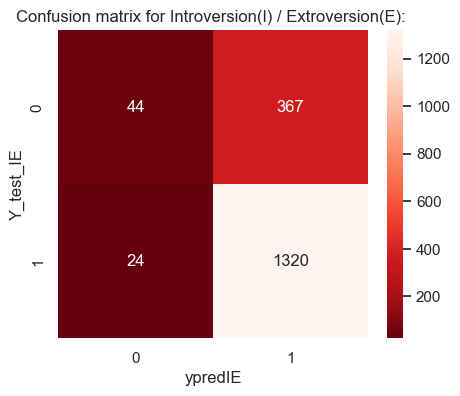

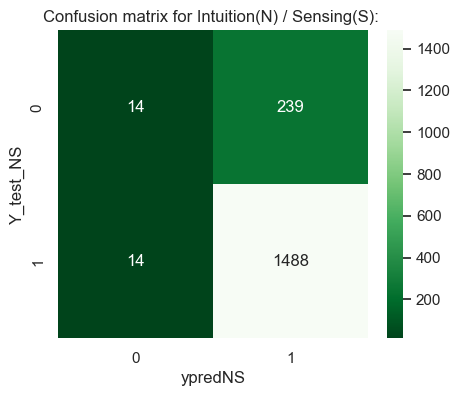

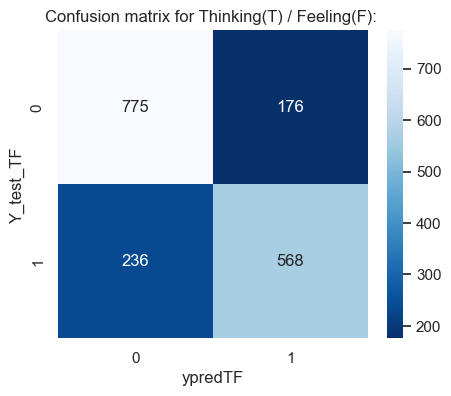

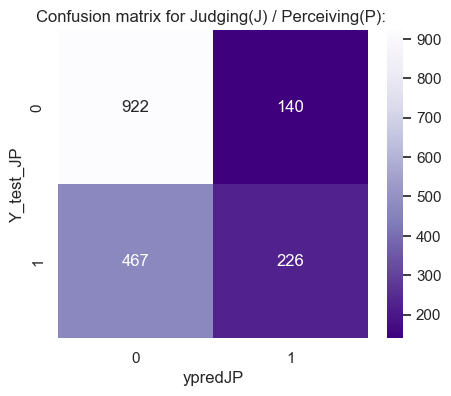

In [66]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

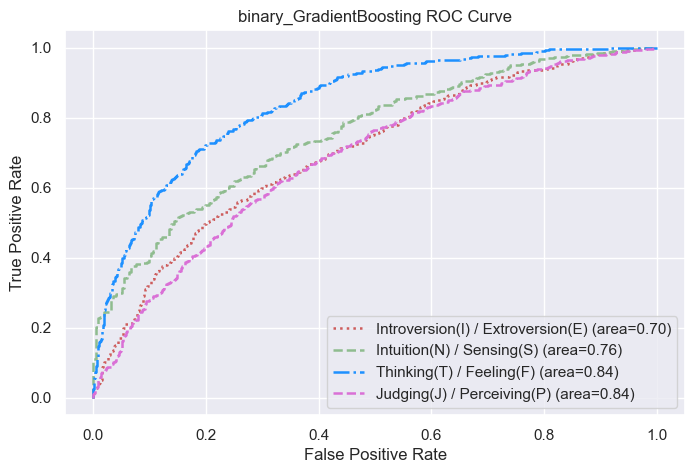

In [67]:
# ROC curve
print_roc_auc_curve(gb_IE.best_estimator_.predict_proba(X_test_IE),
                    gb_NS.best_estimator_.predict_proba(X_test_NS),
                    gb_TF.best_estimator_.predict_proba(X_test_TF),
                    gb_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_GradientBoosting')

## Binary class Test on Celebrity dataset
利用名人 Twitter 資料集來預測陌生資料的 MBTI

In [12]:
def combineRow(data):
	tweet_data = []  
	tmp = data.copy()
	m = tmp['tweet'].str.contains('\w+')
	tmp_ = tmp[m].groupby((~m).cumsum(), as_index=False).agg(', '.join)
	tweet_data.append(tmp_)
	tweet_data = pd.concat(tweet_data)
	return tweet_data

def processEmoji(data):
	'''
	process Emoji which may disappear in Twitter posts
	'''
	for i in range(len(data)):
		post = data.at[i, 'tweet']
		result = re.findall(r'\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[A-Za-z][0-9]\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[A-Za-z][0-9]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][A-Za-z]\\x[A-Za-z][0-9]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[A-Za-z][0-9]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[0-9][0-9]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[0-9][A-Za-z]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[A-Za-z][A-Za-z]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[A-Za-z][0-9]\\x[A-Za-z][0-9]|\\x[A-Za-z][0-9]\\x[0-9][0-9]\\x[0-9][0-9]|\\x[A-Za-z][0-9]\\x[0-9][0-9]\\x[A-Za-z][0-9]\\x[A-Za-z][A-Za-z]\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]|\\x[A-Za-z][0-9]\\x[0-9][0-9]\\x[0-9][A-Za-z]', post)
		string_ = []
		for j in result:
			string_.append(j.encode().decode('unicode_escape').encode("raw_unicode_escape"))
			emoji_list = []
		for k in string_:
			emoji_list.append(k.decode("utf-8", errors='ignore'))
			emoji_text = []
		for m in range(len(emoji_list)):
			emoji_text.append(emoji.demojize(emoji_list[m]))
			post_list = []
		for l in range(len(result)):
			post = post.replace(result[l] , emoji_text[l])
			data.tweet[i] = post
	return data

def Preprocessor_test(text:str, remove_mbti: bool=True) -> list:
	# Cleaning
	text = re.sub(r'\|\|\|', ' ', text)  # Split by separator
	text = re.sub(r'http\S+', ' ', text)  # Replace hyperlink
	text = re.sub(r'\d',' ', text)  # Remove digits
	text = re.sub(r'^b\'', ' ', text)  # Remove b' (某些post開頭會出現)
	text = re.sub(r"[A-Za-z]+\'+\w+", ' ', text)  # Handling apostrophe (e.g. you've, there's)
	text = re.sub(r'x[A-Za-z]', ' ', text)  # Remove unicode
	text = re.sub(r'\b[A-Za-z]\b', ' ', text)  # Remove single letter
	text = re.sub(r"\@+[A-Za-z]+\w+", ' ', text)  # Remove user name
	text = re.sub(r'\bR[A-Z]\b', ' ', text)  # Remove 轉發符號
	text = re.sub(r'[.,"\'\-\+\[\]?:!;@#&()]', ' ', text)  # Remove punctuation
	text = re.sub(r'\\',' ', text)  # Remove punctuation
	text = re.sub(r'[’“”/]', ' ', text)  # Remove punctuation
	text = text.lower()
	if remove_mbti == True:
		text = re.sub('intj|intp|entj|entp|infp|enfj|enfp|istj|isfj|estj|esfj|istp|isfp|estp|esfp|infj', '', text)
	# Tokenization
	tokens = word_tokenize(text)
	filtered_tokens = [w for w in tokens if not w in stopwords.words('english')]  # Remove stopwords
	# Stemming
	stemmer_ = SnowballStemmer("english")
	stemmed = [stemmer_.stem(t) for t in filtered_tokens]
	# Lemmatizing
	lemma = WordNetLemmatizer()
	lemmatized = " ".join([lemma.lemmatize(w) for w in stemmed])
	return lemmatized

	
def test_text(data):
	for i in range(len(data)):
		post = data.loc[i, 'tweet']

		text = Preprocessor_test(post)

		data.tweet[i] = text
	return data

In [70]:
#預測會用到的 function
modelList = {'gNB': [gNB_IE, gNB_NS, gNB_TF, gNB_JP],
            'log': [log_IE, log_NS, log_TF, log_JP],
            'svm': [svm_IE, svm_NS, svm_TF, svm_JP],
            'knn': [knn_IE, knn_NS, knn_TF, knn_JP],
            'dt': [dt_IE, dt_NS, dt_TF, dt_JP],
            'rf': [rf_IE, rf_NS, rf_TF, rf_JP],
            'gb': [gb_IE, gb_NS, gb_TF, gb_JP]}

### Case 1 Adele: ENTJ

In [25]:
def predictMBTI(model:str , svd):
    pred_IE = modelList[str(model)][0].predict(svd)
    pred_NS = modelList[str(model)][1].predict(svd)
    pred_TF = modelList[str(model)][2].predict(svd)
    pred_JP = modelList[str(model)][3].predict(svd)
    
    char = []  # list for storing result
    char.append('I') if pred_IE else char.append('E')
    char.append('N') if pred_NS else char.append('S')
    char.append('T') if pred_TF else char.append('F')
    char.append('J') if pred_JP else char.append('P')

    return ''.join(char)
df_adele = pd.read_csv('../data/Adele.csv')
df_adele

,twitter_id,date,tweet
0,1543973875687596033,2022-07-04 15:03:52+00:00,b'Thank you to my band and my crew for two sea...
1,1543973499508752386,2022-07-04 15:02:22+00:00,b'Hyde Park Night 2! My heart is absolutely fu...
2,1543254652807954439,2022-07-02 15:25:56+00:00,"b'Thank you my loves, I can\xe2\x80\x99t wait ..."
3,1543254498247835648,2022-07-02 15:25:19+00:00,b'Hyde Park Night 1! What a crowd!! https://t....
4,1542530240060194816,2022-06-30 15:27:22+00:00,b'Who\xe2\x80\x99s ready for tomorrow!? https:...
...,...,...,...
360,29513802932,2010-11-02 22:54:44+00:00,b'RT @ColumbiaRecords: NEWS: Adele @OfficialAd...
361,29419669509,2010-11-02 00:05:24+00:00,"b""Head over to Adele's newly re-designed websi..."
362,29104016829,2010-10-29 16:37:36+00:00,b'Adele has a new blog up at http://www.adele....
363,27248872792,2010-10-13 14:58:33+00:00,b'Adele has a new blog up at her website. Chec...


In [73]:
adele_data = combineRow(df_adele)
adele_data = processEmoji(adele_data)
adele_data = test_text(adele_data)
adele_tfidf = vectorizer.transform(adele_data.tweet)
adele_svd = svd.transform(adele_tfidf)
predictMBTI('svm', adele_svd)

'ISFP'

In [74]:
# truth: ENTJ
for idx, (k,v) in enumerate(modelList.items()):
    print(f'Result from model {k}: {predictMBTI(k, adele_svd)}')

Result from model gNB: ISTP
Result from model log: INFP
Result from model svm: ISFP
Result from model knn: ESFP
Result from model dt: INFP
Result from model rf: INFP
Result from model gb: INFP


### Case 2 Anna Kendrick: ENTP

In [57]:
df_anna = pd.read_csv('../data/AnnaKendrick47.csv')
df_anna

,twitter_id,date,tweet
0,1538329814771408896,2022-06-19 01:16:23+00:00,b'@billyeichner @ecareyo Billy!! If you keep t...
1,1538263976689246208,2022-06-18 20:54:46+00:00,b'@billyeichner We can finally live our truth ...
2,1495591654828687363,2022-02-21 02:50:11+00:00,"b'@LouisPeitzman Sir, please do not come for o..."
3,1495470771736514563,2022-02-20 18:49:51+00:00,b'@joshgondelman That\xe2\x80\x99s only becaus...
4,1495167995911360512,2022-02-19 22:46:43+00:00,b'@trixiemattel @Barbie \xf0\x9f\x92\x95\xf0\x...
...,...,...,...
2463,2880005300,2009-07-27 23:47:51+00:00,b'3.To clarify: annakendrick47 is my FIRST & o...
2464,2879979190,2009-07-27 23:46:09+00:00,b'2.Was asked why I didn\xe2\x80\x99t just hav...
2465,2879943758,2009-07-27 23:43:50+00:00,b'1.Must give a big thanks to Rachelle Lefevre...
2466,2831350530,2009-07-25 03:10:40+00:00,b'Seeeeee....... (this is the only twitter I h...


In [58]:
anna_data = combineRow(df_anna)
anna_data = processEmoji(anna_data)
anna_data = test_text(anna_data)
anna_tfidf = vectorizer.transform(anna_data.tweet)
anna_svd = svd.transform(anna_tfidf)

In [77]:
# truth: ENTP
for idx, (k,v) in enumerate(modelList.items()):
    print(f'Result from model {k}: {predictMBTI(k, anna_svd)}')

Result from model gNB: ISTP
Result from model log: INTP
Result from model svm: INTP
Result from model knn: ESFJ
Result from model dt: INFP
Result from model rf: INFP
Result from model gb: INFP


## Multi-class

In [78]:
trainingdf = pd.DataFrame(X_svd)
trainingdf

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.561940,-0.028897,0.190150,-0.139254,0.097786,0.012552,0.036420,0.098107,-0.104731,-0.158202,...,-0.019014,0.014097,-0.008425,-0.013790,0.011261,0.027198,-0.029439,-0.018486,-0.012892,-0.048595
1,0.339056,0.089592,0.007780,-0.003127,-0.005652,-0.013994,0.054352,0.006041,0.010309,-0.059169,...,0.034307,-0.025705,0.040347,0.019400,0.065817,0.001895,0.123126,-0.013323,-0.041209,0.037928
2,0.469067,-0.038349,-0.066268,-0.020078,-0.046394,0.026983,0.018477,-0.077726,0.079365,0.024675,...,0.007333,-0.001699,-0.024683,0.020386,0.016480,0.014917,-0.031046,0.009546,0.035960,0.014488
3,0.375280,-0.026241,0.108852,-0.021977,0.142643,-0.066365,-0.025974,0.076087,-0.017264,-0.127363,...,-0.003902,-0.033900,-0.000307,-0.001272,-0.024661,-0.054984,0.006712,0.021216,0.032402,-0.047842
4,0.366280,-0.053353,0.015346,0.066154,-0.022211,-0.037269,-0.032593,0.017721,-0.020388,-0.000117,...,0.015535,0.022935,0.008683,0.034341,0.010217,-0.012965,0.017995,-0.008308,-0.011627,0.058013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.406399,-0.025567,0.046224,0.003140,-0.079388,0.017564,0.019175,-0.015665,0.020150,-0.016952,...,0.002076,0.024994,0.030158,0.000832,0.022035,0.006602,-0.001907,-0.000924,-0.021350,-0.017918
8768,0.462781,-0.017735,-0.044000,0.021158,-0.050861,-0.010833,0.107649,0.013288,-0.051402,-0.068414,...,-0.004058,-0.029205,-0.056780,-0.006127,-0.023713,0.023429,0.028743,-0.015101,-0.000235,0.019665
8769,0.536752,-0.115784,-0.018707,-0.077973,-0.028030,0.064473,-0.013656,-0.037774,-0.001224,0.027226,...,0.000494,-0.020552,0.021857,0.000887,0.008293,-0.008775,-0.017299,0.001777,0.006293,0.028384
8770,0.529239,-0.088614,0.022369,-0.021674,-0.050712,0.039615,-0.049221,-0.010733,-0.035705,-0.051929,...,0.019239,-0.039108,0.015117,0.003065,-0.032248,-0.015422,0.048138,-0.005772,-0.006894,-0.031048


### XGBoost

In [93]:
# train-test-split
label = data.type
Y = LabelEncoder().fit_transform(label) 
X_train, X_valid, y_train, y_valid = train_test_split(df_svd, Y, test_size=0.2, random_state=42)

In [95]:
# grid search
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
learning_rate=[round(float(x),2) for x in np.linspace(start=0.1, stop=0.2, num=5)]

best_nest = 0
best_lr = 0
best_acc=0

for nest in n_estimators:
    local_acc = 0
    local_lr = 0
    for lr in learning_rate:
        param = {}
        param['n_estimators'] = nest
        param['max_depth'] = 2
        param['learning_rate'] = lr

        xgb = XGBClassifier(**param)
        xgb_model = xgb.fit(X_train,y_train)

        Y_pred = xgb_model.predict(X_valid)
        predictions = [round(value) for value in Y_pred]

        # evaluate predictions
        accuracy = accuracy_score(y_valid, predictions)

        if accuracy > local_acc:
            local_acc = accuracy
            local_lr = lr

        if accuracy > best_acc:
            best_acc = accuracy
            best_nest = nest
            best_lr = lr
    
    print(f'n_estimator = {nest}, learning_rate = {local_lr}, best accuracy = {local_acc} ')

print(f'Result : best n_estimator = {best_nest}, best learning_rate = {best_lr}, best accuracy = {best_acc} ')
print('-----------------------------------------------------------')




param = {}

param['n_estimators'] = best_nest
param['max_depth'] = 2
param['learning_rate'] = best_lr

xgb = XGBClassifier(**param)
xgb_model = xgb.fit(X_train,y_train)

Y_pred = xgb_model.predict(X_valid)
predictions = [round(value) for value in Y_pred]

classification_report(y_valid, predictions)

n_estimator = 100, learning_rate = 0.18, best accuracy = 0.3333333333333333 
n_estimator = 200, learning_rate = 0.12, best accuracy = 0.34415954415954414 
n_estimator = 300, learning_rate = 0.15, best accuracy = 0.34643874643874645 
n_estimator = 400, learning_rate = 0.12, best accuracy = 0.34814814814814815 
n_estimator = 500, learning_rate = 0.12, best accuracy = 0.34814814814814815 
n_estimator = 600, learning_rate = 0.12, best accuracy = 0.3544159544159544 
n_estimator = 700, learning_rate = 0.18, best accuracy = 0.34643874643874645 
n_estimator = 800, learning_rate = 0.12, best accuracy = 0.350997150997151 
n_estimator = 900, learning_rate = 0.12, best accuracy = 0.35327635327635326 
n_estimator = 1000, learning_rate = 0.12, best accuracy = 0.3504273504273504 
Result : best n_estimator = 600, best learning_rate = 0.12, best accuracy = 0.3544159544159544 
-----------------------------------------------------------


'              precision    recall  f1-score   support\n\n           0       0.40      0.04      0.08        45\n           1       0.28      0.20      0.23       133\n           2       0.29      0.04      0.07        52\n           3       0.32      0.21      0.25       144\n           4       0.67      0.20      0.31        10\n           5       0.00      0.00      0.00        16\n           6       0.00      0.00      0.00         9\n           7       0.00      0.00      0.00        20\n           8       0.32      0.41      0.36       295\n           9       0.39      0.63      0.48       342\n          10       0.36      0.33      0.34       242\n          11       0.36      0.46      0.41       256\n          12       0.60      0.07      0.12        43\n          13       0.12      0.05      0.07        41\n          14       0.29      0.05      0.08        41\n          15       0.42      0.27      0.33        66\n\n    accuracy                           0.35      1755\n   ma

In [101]:
Y_pred = xgb_model.predict(X_valid)
predictions = [round(value) for value in Y_pred]

print(classification_report(y_valid, predictions))

# # evaluate predictions

              precision    recall  f1-score   support

           0       0.40      0.04      0.08        45
           1       0.28      0.20      0.23       133
           2       0.29      0.04      0.07        52
           3       0.32      0.21      0.25       144
           4       0.67      0.20      0.31        10
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        20
           8       0.32      0.41      0.36       295
           9       0.39      0.63      0.48       342
          10       0.36      0.33      0.34       242
          11       0.36      0.46      0.41       256
          12       0.60      0.07      0.12        43
          13       0.12      0.05      0.07        41
          14       0.29      0.05      0.08        41
          15       0.42      0.27      0.33        66

    accuracy                           0.35      1755
   macro avg       0.30   

### SVM

In [99]:
svm_m = SVC(kernel = 'linear')
svm_m.fit(X_train,y_train)
predictions = svm_m.predict(X_valid)

print(classification_report(y_valid, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.41      0.07      0.12       133
           2       0.00      0.00      0.00        52
           3       0.27      0.10      0.14       144
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        20
           8       0.33      0.34      0.33       295
           9       0.34      0.73      0.47       342
          10       0.36      0.28      0.31       242
          11       0.34      0.60      0.43       256
          12       0.00      0.00      0.00        43
          13       0.00      0.00      0.00        41
          14       0.00      0.00      0.00        41
          15       0.00      0.00      0.00        66

    accuracy                           0.34      1755
   macro avg       0.13   

### Logistic Regression

In [98]:
logreg_m = LogisticRegression()
logreg_m.fit(X_train, y_train)

predictions = logreg_m.predict(X_valid)
print(classification_report(y_valid, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.29      0.14      0.19       133
           2       0.00      0.00      0.00        52
           3       0.29      0.13      0.18       144
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        20
           8       0.32      0.36      0.34       295
           9       0.37      0.71      0.48       342
          10       0.36      0.31      0.33       242
          11       0.35      0.55      0.43       256
          12       0.00      0.00      0.00        43
          13       0.00      0.00      0.00        41
          14       0.00      0.00      0.00        41
          15       0.62      0.08      0.14        66

    accuracy                           0.35      1755
   macro avg       0.16   

### RandomForest

In [102]:
random_forest = RandomForestClassifier(n_estimators=1000, random_state = 42, class_weight = 'balanced')
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_valid)
print(classification_report(y_valid, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       1.00      0.01      0.01       133
           2       0.00      0.00      0.00        52
           3       0.25      0.01      0.01       144
           4       1.00      0.10      0.18        10
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        20
           8       0.29      0.19      0.23       295
           9       0.26      0.85      0.40       342
          10       0.45      0.14      0.22       242
          11       0.34      0.48      0.40       256
          12       0.00      0.00      0.00        43
          13       0.12      0.02      0.04        41
          14       1.00      0.02      0.05        41
          15       0.00      0.00      0.00        66

    accuracy                           0.29      1755
   macro avg       0.29   

### KNN

In [104]:
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train, y_train)
predictions = knn.predict(X_valid)
print(classification_report(y_valid, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.40      0.05      0.08       133
           2       0.00      0.00      0.00        52
           3       0.41      0.05      0.09       144
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        20
           8       0.26      0.28      0.27       295
           9       0.34      0.61      0.44       342
          10       0.31      0.20      0.24       242
          11       0.28      0.68      0.40       256
          12       0.00      0.00      0.00        43
          13       0.00      0.00      0.00        41
          14       0.00      0.00      0.00        41
          15       0.00      0.00      0.00        66

    accuracy                           0.30      1755
   macro avg       0.12   

### LGBM

In [107]:
model = lgb.LGBMClassifier(is_unbalance=True)
model.fit(X_train,y_train)
predictions = model.predict(X_valid)
print(classification_report(y_valid, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.30      0.14      0.19       133
           2       0.00      0.00      0.00        52
           3       0.43      0.19      0.27       144
           4       1.00      0.20      0.33        10
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        20
           8       0.30      0.38      0.33       295
           9       0.34      0.64      0.45       342
          10       0.33      0.27      0.30       242
          11       0.35      0.51      0.41       256
          12       0.00      0.00      0.00        43
          13       0.12      0.02      0.04        41
          14       0.50      0.02      0.05        41
          15       0.48      0.15      0.23        66

    accuracy                           0.34      1755
   macro avg       0.26   

### DNN

In [17]:
temp_data = data['type'].value_counts().reset_index().sort_values(by='index')
temp_data['class_weight'] =   temp_data['type'].sum() / (temp_data.shape[0] * temp_data['type'])
temp_data = temp_data.reset_index()
class_weights = temp_data['class_weight'].to_dict()
class_weights

{0: 2.8406735751295336,
 1: 0.8050660792951542,
 2: 2.342948717948718,
 3: 0.7899855907780979,
 4: 10.54326923076923,
 5: 8.56640625,
 6: 12.75,
 7: 5.832446808510638,
 8: 0.3724524456521739,
 9: 0.29877384196185286,
 10: 0.5016010978957,
 11: 0.42011494252873566,
 12: 3.206140350877193,
 13: 1.9236842105263159,
 14: 2.648550724637681,
 15: 1.570916905444126}

In [18]:
# one hot encoding
onehotencoder = OneHotEncoder()
onehot = onehotencoder.fit_transform(data[['type']]).toarray()
y_train_df = pd.DataFrame(onehot)

In [20]:
# train test split
X = X_svd
y = y_train_df.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [69]:
model = Sequential()

model.add(Dense(units=128, input_dim=100, activation='relu')) 
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu', kernel_regularizer='l2')) 
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=64, activation='relu', kernel_regularizer='l2')) 
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Add output layer
model.add(Dense(units=16, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  

In [70]:
model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, class_weight=class_weights)

Epoch 1/50
198/198 [==============================] - 4s 11ms/step - loss: 5.0273 - accuracy: 0.0766 - val_loss: 4.1809 - val_accuracy: 0.0285
Epoch 2/50
198/198 [==============================] - 2s 9ms/step - loss: 4.2936 - accuracy: 0.1006 - val_loss: 3.9609 - val_accuracy: 0.0470
Epoch 3/50
198/198 [==============================] - 2s 9ms/step - loss: 3.8226 - accuracy: 0.1325 - val_loss: 3.7268 - val_accuracy: 0.1282
Epoch 4/50
198/198 [==============================] - 2s 10ms/step - loss: 3.5486 - accuracy: 0.1441 - val_loss: 3.4841 - val_accuracy: 0.1709
Epoch 5/50
198/198 [==============================] - 2s 10ms/step - loss: 3.3043 - accuracy: 0.1576 - val_loss: 3.2888 - val_accuracy: 0.1909
Epoch 6/50
198/198 [==============================] - 2s 10ms/step - loss: 3.0984 - accuracy: 0.1810 - val_loss: 3.1765 - val_accuracy: 0.1937
Epoch 7/50
198/198 [==============================] - 2s 10ms/step - loss: 2.9551 - accuracy: 0.1907 - val_loss: 3.0408 - val_accuracy: 0.2037
E

In [24]:
y_pred = model.predict(X_test)
y_pred_list = []
total_ypred_list = []
for ele in y_pred:
    empty_list = np.zeros(16)
    temp_list = list(ele)
    idx_ = temp_list.index(ele.max())
    empty_list[idx_] = 1
    total_ypred_list.append(list(empty_list))
print(classification_report(y_test, total_ypred_list))

55/55 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.04      0.08      0.05        39
           1       0.21      0.28      0.24       136
           2       0.07      0.17      0.10        47
           3       0.33      0.40      0.36       139
           4       0.05      0.10      0.07        10
           5       0.03      0.08      0.04        13
           6       0.00      0.00      0.00         9
           7       0.04      0.11      0.06        19
           8       0.43      0.24      0.31       294
           9       0.55      0.26      0.35       367
          10       0.31      0.28      0.29       219
          11       0.40      0.27      0.32       261
          12       0.11      0.12      0.11        34
          13       0.09      0.26      0.14        57
          14       0.07      0.10      0.08        41
          15       0.18      0.36      0.24        70

   micro avg       0.26    

### 1D CNN

In [66]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(100,1)))
model.add(BatchNormalization())
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(BatchNormalization())
model.add(Dense(16, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [67]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, callbacks=es)

Epoch 1/50
198/198 [==============================] - 5s 17ms/step - loss: 2.8773 - accuracy: 0.1525 - val_loss: 2.5834 - val_accuracy: 0.1211
Epoch 2/50
198/198 [==============================] - 3s 15ms/step - loss: 2.3385 - accuracy: 0.2464 - val_loss: 2.3233 - val_accuracy: 0.1738
Epoch 3/50
198/198 [==============================] - 3s 16ms/step - loss: 2.1967 - accuracy: 0.2719 - val_loss: 2.1479 - val_accuracy: 0.2821
Epoch 4/50
198/198 [==============================] - 3s 15ms/step - loss: 2.1100 - accuracy: 0.3028 - val_loss: 2.0408 - val_accuracy: 0.2991
Epoch 5/50
198/198 [==============================] - 3s 15ms/step - loss: 2.0720 - accuracy: 0.3034 - val_loss: 2.0097 - val_accuracy: 0.3205
Epoch 6/50
198/198 [==============================] - 3s 15ms/step - loss: 2.0320 - accuracy: 0.3259 - val_loss: 1.9971 - val_accuracy: 0.3191
Epoch 7/50
198/198 [==============================] - 4s 18ms/step - loss: 1.9943 - accuracy: 0.3287 - val_loss: 1.9724 - val_accuracy: 0.3276

In [55]:
y_pred = model.predict(X_test)
total_ypred_list = []
for ele in y_pred:
    empty_list = np.zeros(16)
    temp_list = list(ele)
    idx_ = temp_list.index(ele.max())
    empty_list[idx_] = 1
    total_ypred_list.append(list(empty_list))

print(classification_report(y_test, total_ypred_list))

55/55 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.31      0.17      0.22       136
           2       0.32      0.13      0.18        47
           3       0.30      0.37      0.33       139
           4       0.00      0.00      0.00        10
           5       0.04      0.08      0.05        13
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        19
           8       0.40      0.31      0.35       294
           9       0.38      0.66      0.48       367
          10       0.36      0.32      0.34       219
          11       0.36      0.44      0.40       261
          12       0.75      0.09      0.16        34
          13       0.31      0.09      0.14        57
          14       0.20      0.05      0.08        41
          15       0.27      0.19      0.22        70

   micro avg       0.35    

## Multi-class Test on Celebrity dataset
利用名人 Twitter 資料集來預測陌生資料的 MBTI
### Case 1 Adele: ENTJ

In [28]:
types_16 = ['ENFJ','ENFP' ,'ENTJ' ,'ENTP' 
            ,'ESFJ' ,'ESFP' ,'ESTJ' ,'ESTP' 
            ,'INFJ' ,'INFP' ,'INTJ' ,'INTP' 
            ,'ISFJ' ,'ISFP' ,'ISTJ' ,'ISTP']  

In [209]:
svm_results = types_16[svm_m.predict(adele_svd)[0]]
rf_results = types_16[random_forest.predict(adele_svd)[0]]
lr_results = types_16[logreg_m.predict(adele_svd)[0]]
knn_results = types_16[knn.predict(adele_svd)[0]]
lgb_results = types_16[model.predict(adele_svd)[0]]
xgb_results = types_16[xgb_model.predict(adele_svd)[0]]

In [51]:
dnn_idx = list(model.predict(adele_svd)[0]).index(model.predict(adele_svd)[0].max())
print('Results from model dnn :',types_16[dnn_idx])

1/1 [==============================] - 0s 28ms/step
Results from model dnn : ESFJ


In [56]:
cnn_idx = list(model.predict(adele_svd)[0]).index(model.predict(adele_svd)[0].max())
print('Results from model 1D CNN :',types_16[cnn_idx])

1/1 [==============================] - 0s 34ms/step
Results from model 1D CNN : ESFP


In [211]:
print('Results from model svm :', svm_results)
print('Results from model rf :', rf_results)
print('Results from model lr :', lr_results)
print('Results from model knn :', knn_results)
print('Results from model lgb :', lgb_results)
print('Results from model xgb :', xgb_results)

Results from model svm : INFP
Results from model rf : INFP
Results from model lr : INFP
Results from model knn : INFP
Results from model lgb : INFP
Results from model xgb : ISFP


### Case 2 Anna Kendrick: ENTP

In [214]:
print('Results from model svm :', svm_results)
print('Results from model rf :', rf_results)
print('Results from model lr :', lr_results)
print('Results from model knn :', knn_results)
print('Results from model lgb :', lgb_results)
print('Results from model xgb :', xgb_results)

Results from model svm : INTP
Results from model rf : INFP
Results from model lr : INTP
Results from model knn : INTP
Results from model lgb : INFP
Results from model xgb : INFP


In [68]:
cnn_idx = list(model.predict(anna_svd)[0]).index(model.predict(anna_svd)[0].max())
print('Results from model 1D CNN :',types_16[cnn_idx])

1/1 [==============================] - 0s 33ms/step
Results from model 1D CNN : ENTP


In [71]:
dnn_idx = list(model.predict(anna_svd)[0]).index(model.predict(anna_svd)[0].max())
print('Results from model DNN :',types_16[dnn_idx])

1/1 [==============================] - 0s 36ms/step
Results from model DNN : ENFP


## Fine-tune your models and combine them into a great solution.